In [2]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/user/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

#folder_path = '/home/user/thesis_ws/src/RobotData_GRIPA320'
data_folder = '/home/user/thesis_ws/src/ML_Levers_Knobs/DATA/1D_LEVER_Fx'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 2000

2024-05-14 14:56:50.143647: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 14:56:51.087263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_data shape: (478, 2000)
y_data shape: (478,)
X_data.[0] shape:  (2000,)
TOTAL DATA: 478  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (286, 2000)    ||  Dimensions of y_train: (286,)
Dimensions of X_test:  (96, 2000)    ||  Dimensions of y_test:  (96,)
Dimensions of X_val:   (96, 2000)    ||  Dimensions of y_val:   (96,)


2024-05-14 14:56:51.721970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 14:56:51.753684: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 14:56:51.753946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 1st COMBINED (96%)

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-05-14 12:32:49.007830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 12:32:49.008402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 12:32:49.008693: I e

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │     42,464 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32)        │    129,800 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        291 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,555 (674.04 KB)

 Trainable params: 172,555 (674.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22


I0000 00:00:1715682771.688926   54801 service.cc:145] XLA service 0x7a2c7c010bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715682771.688949   54801 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-05-14 12:32:51.768809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 12:32:52.114271: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3812 - loss: 1.1223

I0000 00:00:1715682776.371453   54801 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 638ms/step - accuracy: 0.4097 - loss: 1.0797 - val_accuracy: 0.5417 - val_loss: 1.0799
Epoch 2/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5544 - loss: 0.9708 - val_accuracy: 0.5938 - val_loss: 0.9154
Epoch 3/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6247 - loss: 0.8495 - val_accuracy: 0.7188 - val_loss: 0.7412
Epoch 4/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7550 - loss: 0.6799 - val_accuracy: 0.7708 - val_loss: 0.6132
Epoch 5/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8233 - loss: 0.4928 - val_accuracy: 0.8229 - val_loss: 0.5221
Epoch 6/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8663 - loss: 0.3766 - val_accuracy: 0.8229 - val_loss: 0.5203
Epoch 7/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8940 - loss: 0.3077 - val_accuracy: 0.8125 - val_loss: 0.4541
Epoch 8/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9124 - loss: 0.2663 - val_accuracy: 0.8542 - val_loss: 0.4582
Epoch 9/2

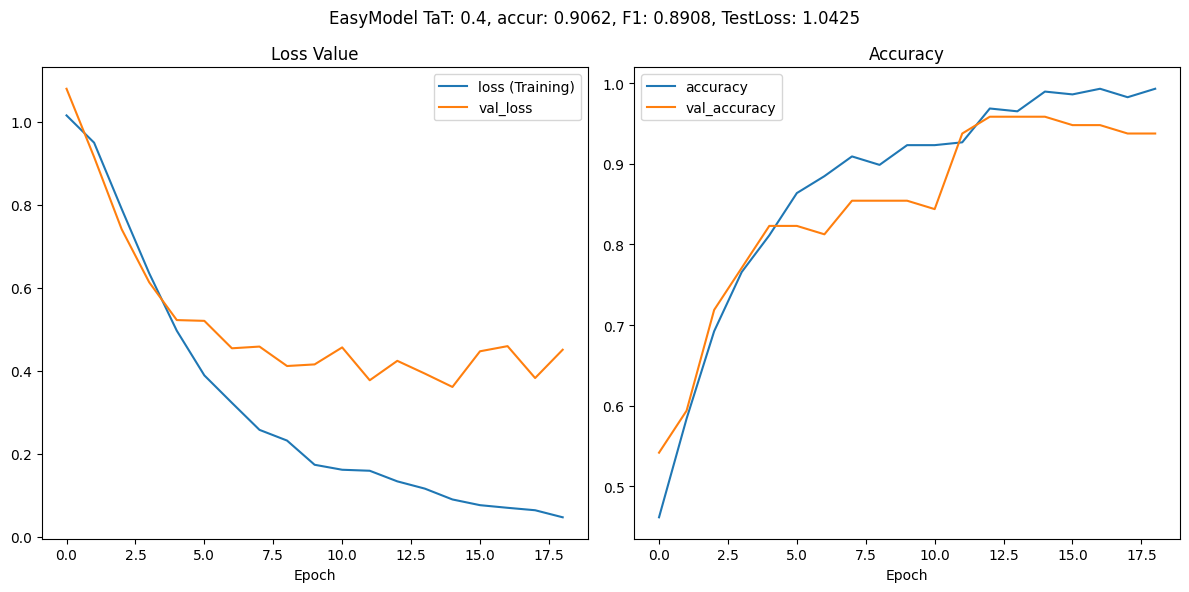

Train loss: 0.046630535274744034
Test val_loss: 0.4506600797176361
Train accuracy: 0.9930070042610168
Accuracy Score: 0.90625
F1 Score: 0.8907543773523154
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95        47
         1.0       0.96      0.79      0.87        33
         2.0       0.79      0.94      0.86        16

    accuracy                           0.91        96
   macro avg       0.89      0.90      0.89        96
weighted avg       0.91      0.91      0.91        96



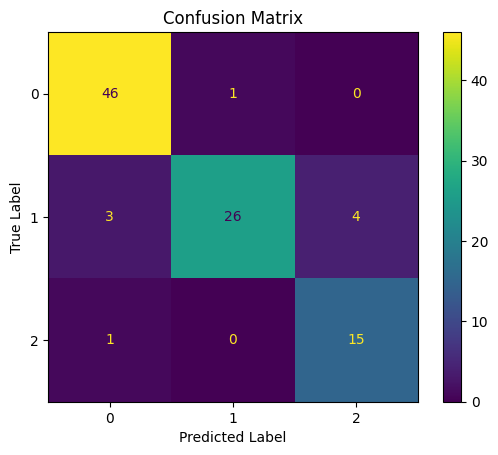

In [2]:
def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(filters=32, kernel_size=40, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=4))
    model1.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    #model1.add(Flatten())
    model1.add(Dense(64, activation='relu'))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=32, kernel_size=20, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=8, kernel_size=8, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    model2.add(Flatten())
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(rate=0.1))
    model2.add(Dense(32, activation='relu'))
    
    output2 = model2(input2)

    merged = Concatenate()([output1, output2])
    merged = Dense(3, activation='softmax')(merged)
    combined_model = Model(inputs=[input1, input2], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit([X_train,X_train], [y_train, y_train], epochs=22, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["0", "1", "2"])
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# COMBINED 3 Branches

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64)        │     42,784 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 32)        │     28,432 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 32)        │    166,608 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ sequential_3[0][… │
│ (Concatenate)       │                   │            │ sequential_4[0][… │
│                     │                   │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 3)         │        387 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 238,211 (930.51 KB)

 Trainable params: 238,211 (930.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 557ms/step - accuracy: 0.4392 - loss: 1.1009 - val_accuracy: 0.6771 - val_loss: 0.8750
Epoch 2/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7564 - loss: 0.7078 - val_accuracy: 0.7188 - val_loss: 0.6463
Epoch 3/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8459 - loss: 0.5801 - val_accuracy: 0.8125 - val_loss: 0.5002
Epoch 4/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8841 - loss: 0.4253 - val_accuracy: 0.8125 - val_loss: 0.4920
Epoch 5/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9295 - loss: 0.2746 - val_accuracy: 0.8125 - val_loss: 0.3951
Epoch 6/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8920 - loss: 0.3309 - val_accuracy: 0.8438 - val_loss: 0.3670
Epoch 7/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9206 - loss: 0.2590 - val_accuracy: 0.8333 - val_loss: 0.3888
Epoch 8/22
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9234 - loss: 0.2234 - val_accuracy: 0.8958 - val_loss: 0.305

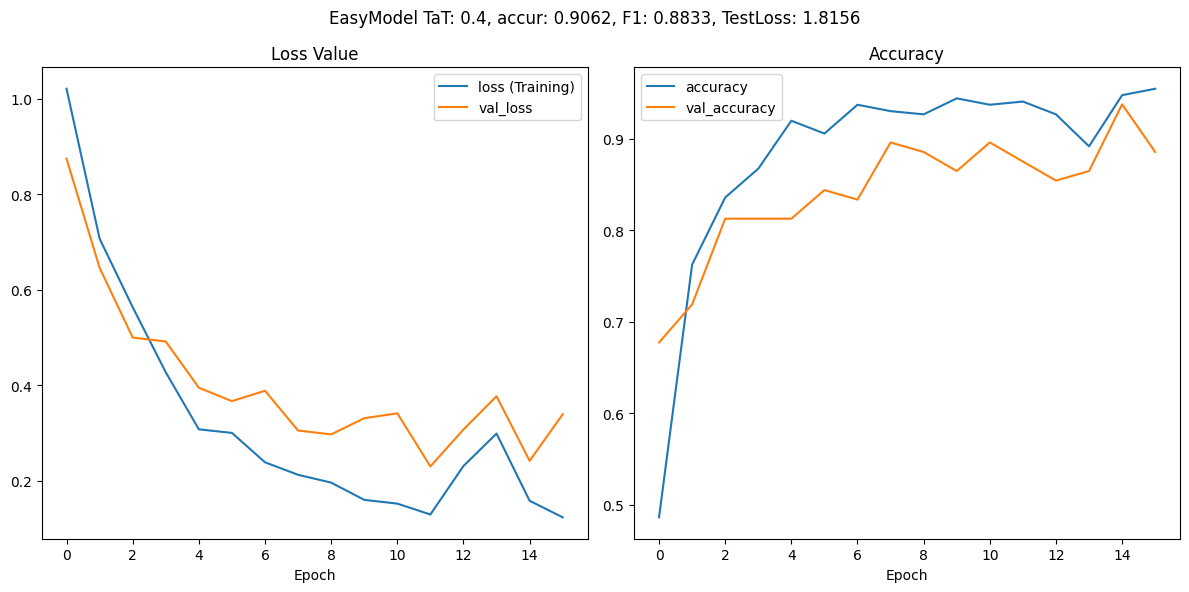

Train loss: 0.1236286535859108
Test val_loss: 0.3394812047481537
Train accuracy: 0.9545454382896423
Accuracy Score: 0.90625
F1 Score: 0.8833092833092833
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93        47
         1.0       0.97      0.88      0.92        33
         2.0       0.86      0.75      0.80        16

    accuracy                           0.91        96
   macro avg       0.90      0.87      0.88        96
weighted avg       0.91      0.91      0.90        96



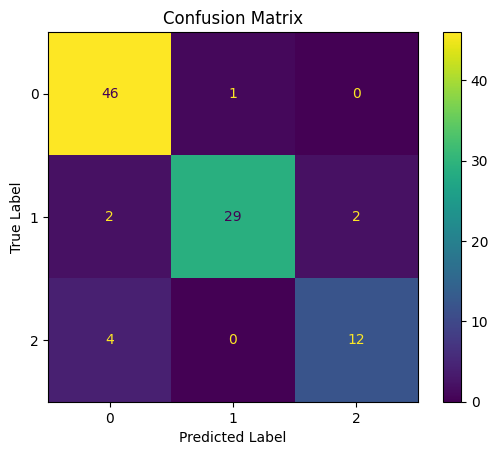

In [3]:
def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(filters=32, kernel_size=50, strides=10, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=4))
    model1.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    #model1.add(Flatten())
    model1.add(Dense(64, activation='relu'))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=32, kernel_size=20, strides=10, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=16, kernel_size=8, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    model2.add(Flatten())
    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(rate=0.2))
    model2.add(Dense(32, activation='relu'))
    
    output2 = model2(input2)

    # Third Model
    input3 = Input(shape=input_shape)
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=40, activation='relu', input_shape=input_shape))
    model3.add(MaxPooling1D(pool_size=4))
    model3.add(Conv1D(filters=32, kernel_size=20, activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=16, kernel_size=10, activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Flatten())
    model3.add(Dense(64, activation='relu'))
    model3.add(Dropout(rate=0.2))
    model3.add(Dense(32, activation='relu'))
    
    output3 = model3(input3)

    merged = Concatenate()([output1, output2, output3])
    merged = Dense(3, activation='softmax')(merged)
    combined_model = Model(inputs=[input1, input2, input3], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit([X_train, X_train, X_train], [y_train, y_train, y_train], epochs=22, batch_size=32, validation_data=([X_val, X_val, X_val], [y_val, y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test, X_test], [y_test, y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["0", "1", "2"])
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# BEST EASY BIG KERNEL + SMALL KERNEL

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_208"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_36      │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_20       │ (None, 128)       │    330,816 │ input_layer_34[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_21       │ (None, 128)       │    164,480 │ input_layer_36[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 256)       │          0 │ sequential_20[0]… │
│ (Concatenate)       │                   │            │ sequential_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 64)        │     16,448 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 3)         │        195 │ dense_45[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 511,939 (1.95 MB)

 Trainable params: 511,939 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 746ms/step - accuracy: 0.3778 - loss: 1.1369 - val_accuracy: 0.4792 - val_loss: 1.0307
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6300 - loss: 0.9320 - val_accuracy: 0.6771 - val_loss: 0.9200
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7305 - loss: 0.7321 - val_accuracy: 0.7500 - val_loss: 0.6920
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8531 - loss: 0.5480 - val_accuracy: 0.7396 - val_loss: 0.6798
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8022 - loss: 0.5133 - val_accuracy: 0.8229 - val_loss: 0.4992
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8221 - loss: 0.4452 - val_accuracy: 0.7604 - val_loss: 0.5258
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8211 - loss: 0.4762 - val_accuracy: 0.6979 - val_loss: 0.8165
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7936 - loss: 0.5765 - val_accuracy: 0.6771 - val_loss: 0.594

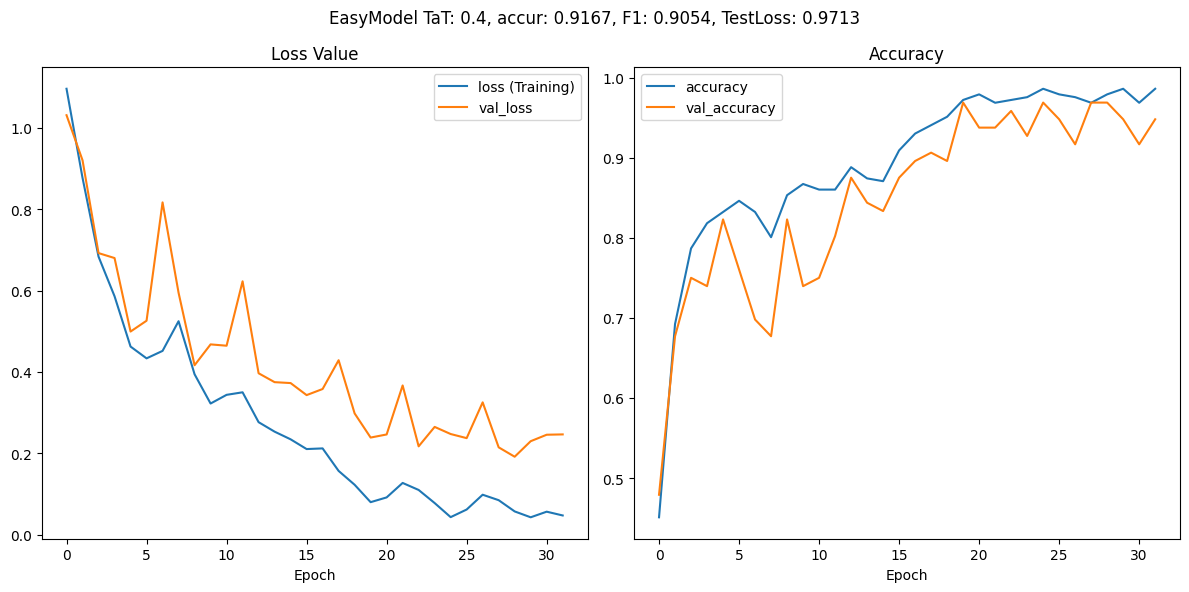

Train loss: 0.0474325567483902
Test val_loss: 0.2465640753507614
Train accuracy: 0.9860140085220337
Accuracy Score: 0.9166666666666666
F1 Score: 0.9053508170210791
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95        47
         1.0       0.96      0.82      0.89        33
         2.0       0.83      0.94      0.88        16

    accuracy                           0.92        96
   macro avg       0.91      0.91      0.91        96
weighted avg       0.92      0.92      0.92        96



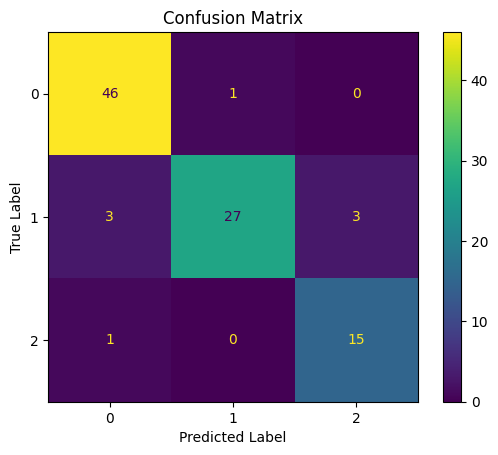

In [11]:

def build_combined_model(input_shape):
    # First Model
    input1 = Input(shape=input_shape)
    model1 = Sequential()
    model1.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=input_shape))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(128, kernel_size=20, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    model1.add(Conv1D(256, kernel_size=4, activation='relu'))
    model1.add(GlobalMaxPooling1D())
    model1.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.2))
    output1 = model1(input1)

    # Second Model
    input2 = Input(shape=input_shape)
    model2 = Sequential()
    model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model2.add(MaxPooling1D(pool_size=4))
    model2.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
    model2.add(Dropout(rate=0.2))
    model2.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
    model2.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model2.add(GlobalMaxPooling1D())
    model2.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.2))
    output2 = model2(input2)

    merged = Concatenate()([output1, output2])
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(3, activation='softmax')(merged)
    combined_model = Model(inputs=[input1, input2], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit([X_train,X_train], [y_train, y_train], epochs=32, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["0", "1", "2"])
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Probably Improved Best Combined

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-05-14 14:57:06.379601: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 14:57:06.380128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 14:57:06.380340: I e

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 2000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │        195 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,011 (1.78 MB)

 Trainable params: 467,011 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32


I0000 00:00:1715691429.395743   15191 service.cc:145] XLA service 0x77cbb40059b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715691429.395770   15191 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-05-14 14:57:09.473633: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 14:57:09.849459: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-05-14 14:57:12.666893: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-14 14:57:13.395252: W external/local_tsl/tsl/framework/bfc_allocator.cc:296]

7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3036 - loss: 1.0987

I0000 00:00:1715691436.873469   15191 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-14 14:57:20.151292: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-14 14:57:20.851195: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-14 14:57:20.899949: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.05GiB with freed_by_count=0. The caller indicates that this is not a failure

9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 996ms/step - accuracy: 0.3394 - loss: 1.0928 - val_accuracy: 0.4479 - val_loss: 1.0845
Epoch 2/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5463 - loss: 1.0417 - val_accuracy: 0.6146 - val_loss: 0.9869
Epoch 3/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6535 - loss: 0.8749 - val_accuracy: 0.7083 - val_loss: 0.7455
Epoch 4/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7992 - loss: 0.6289 - val_accuracy: 0.7708 - val_loss: 0.5306
Epoch 5/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8182 - loss: 0.5065 - val_accuracy: 0.7812 - val_loss: 0.5443
Epoch 6/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8645 - loss: 0.4202 - val_accuracy: 0.7917 - val_loss: 0.4370
Epoch 7/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8794 - loss: 0.3638 - val_accuracy: 0.8125 - val_loss: 0.5192
Epoch 8/32
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8523 - loss: 0.3415 - val_accuracy: 0.7917 - val_loss: 0.4915
Epoch 9/3

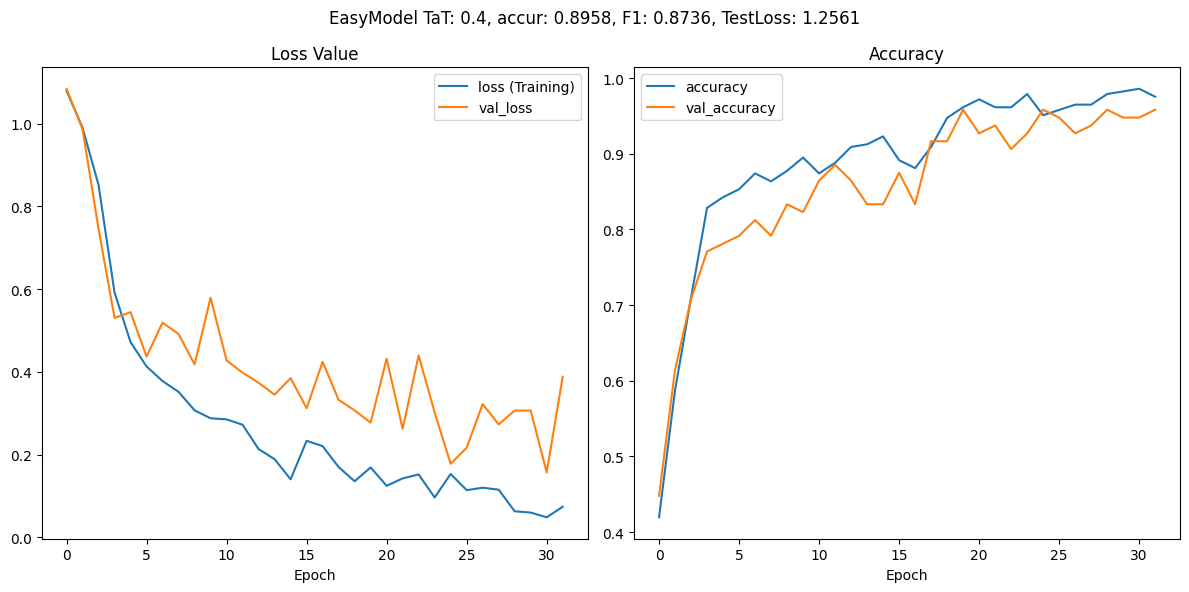

Train loss: 0.07389906048774719
Test val_loss: 0.38824620842933655
Train accuracy: 0.9755244851112366
Accuracy Score: 0.8958333333333334
F1 Score: 0.8735722119049639
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96        47
         1.0       0.93      0.79      0.85        33
         2.0       0.71      0.94      0.81        16

    accuracy                           0.90        96
   macro avg       0.87      0.89      0.87        96
weighted avg       0.91      0.90      0.90        96



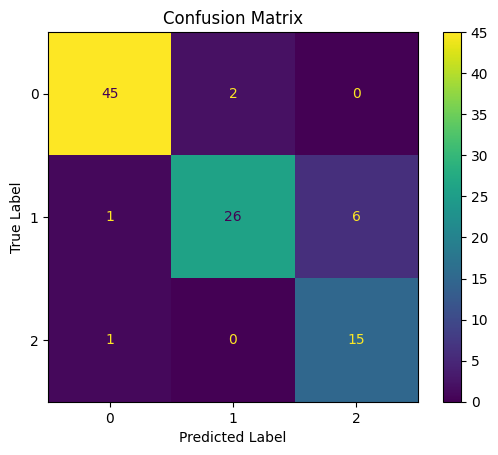

In [3]:

def build_combined_model(input_shape):
    force_input = Input(shape=input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.2))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)
    
    merged = concatenate([outF1, outF2])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(3, activation='softmax')(merged)
    combined_model = Model(inputs=[force_input, force_input], outputs=merged)

    return combined_model


model = build_combined_model((WS_B, 1))
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit([X_train,X_train], [y_train, y_train], epochs=32, batch_size=32, validation_data=([X_val, X_val], [y_val, y_val]), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test, X_test], [y_test, y_test])

# Predict labels for test data
y_pred = model.predict([X_test, X_test])
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["0", "1", "2"])
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()